In [1]:
# Import required packages

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, learning_curve, validation_curve,cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, homogeneity_score, completeness_score

from scipy.stats import  kurtosis

import seaborn as sns
import matplotlib.pyplot as plt
import time

import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

**Import and Preprocess Seeds dataset**

1. Import the Seeds dataset.
2. Split the dataset into training and testing. Keep the testing dataset aside for final model evaluation.
3. Scale the training and testing dataset separately such that all features contribute uniformly to cluster based algorithm.
4. Analyze the distribution of target classes in Seeds dataset using a barplot. 

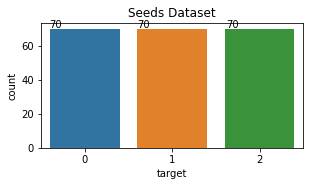

In [2]:
####### Import and preliminary processing of Seeds dataset #############

seeds=pd.read_csv('Seed_Data.csv')

# Split data into training and testing
train_seeds, test_seeds = train_test_split(seeds, test_size=0.2, random_state=42)

# Define the X and Y
y_train_seeds = train_seeds.target
X_train_seeds = train_seeds.drop(['target'], axis=1)

y_test_seeds = test_seeds.target
X_test_seeds = test_seeds.drop(['target'], axis=1)

# Initialize and fit StandardScaler on the seeds dataset
scaler = StandardScaler()
X_train_scaled_seeds = scaler.fit_transform(X_train_seeds)
X_test_scaled_seeds = scaler.transform(X_test_seeds)

# Analyze the distribution of target classes in Seeds dataset

plt.figure(figsize=(4.7, 2.3))
ax=sns.countplot('target',data=seeds)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
ax.set_title('Seeds Dataset')
plt.show()

**Import and Preprocess Obesity dataset**

1. Import the Obesity dataset.
2. Split the dataset into training and testing. Keep the testing dataset aside for final model evaluation.
3. Scale the training and testing dataset separately such that all features contribute uniformly to cluster based algorithm.
4. Analyze the distribution of target classes in Seeds dataset using a barplot.

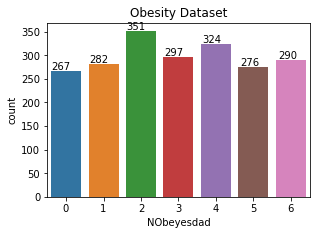

In [3]:
####### Import and preliminary processing of Obesity dataset #############

obesity=pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

# Synthetic data has float for some categorical features. Ensure consistent by rounding off to nearest integer
columns = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]

# convert to int / nearest int value
for col in columns:
    #round to nearest whole number
    obesity[col] = round(obesity[col]).astype('int')
    
# Obesity dataset has duplicate entries. drop them
obesity.drop_duplicates(inplace=True)

# Select categorical columns
cat_cols = [cname for cname in obesity.columns if obesity[cname].dtype=='object']

for col in cat_cols:
    le = LabelEncoder()
    obesity[col] = le.fit_transform(obesity[col])
    
    
# Split data into training and testing    
train_obesity, test_obesity = train_test_split(obesity, test_size=0.2, random_state=42)

# Define the X and Y
y_train_obesity = train_obesity.NObeyesdad
X_train_obesity = train_obesity.drop(['NObeyesdad'], axis=1)

y_test_obesity = test_obesity.NObeyesdad
X_test_obesity = test_obesity.drop(['NObeyesdad'], axis=1)

# Initialize and fit StandardScaler on the Obesity dataset
scaler = StandardScaler()
X_train_scaled_obesity = scaler.fit_transform(X_train_obesity)
X_test_scaled_obesity = scaler.transform(X_test_obesity)

# Analyze the distribution of target classes in Obesity dataset

plt.figure(figsize=(4.7, 3.2))
ax=sns.countplot('NObeyesdad',data=obesity)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
    
ax.set_title('Obesity Dataset')
plt.show()

# I. Clustering Algorithms

This part will focus on the following clustering algorithms applied on Seeds and Obesity datasets:

1. Expectation Maximization
2. K-Means clustering

**1. Expectation Maximization**

1. Select optimal number of clusters using BIC/AIC scores plot.
2. Evaluate the quality of the cluster count using silhouette, homogeneity and completeness scores.

In [4]:
def run_em(X_train, y_train, max_clusters=10, data_name='Seeds'):
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []

    cluster_range = range(2, max_clusters + 1)
    for n_clusters in cluster_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm.fit(X_train)
        cluster_labels = gmm.predict(X_train)
        
        bic_scores.append(gmm.bic(X_train))
        aic_scores.append(gmm.aic(X_train))
        silhouette_scores.append(silhouette_score(X_train, cluster_labels))
        homogeneity_scores.append(homogeneity_score(y_train, cluster_labels))
        completeness_scores.append(completeness_score(y_train, cluster_labels))

    # Plot BIC and AIC Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(cluster_range, bic_scores, marker='o', label='BIC')
    plt.plot(cluster_range, aic_scores, marker='o', label='AIC')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'BIC and AIC (EM): {data_name} dataset')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Plot Silhouette, Homogeneity, and Completeness Scores
    plt.figure(figsize=(4.7, 2.6))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette')
    plt.plot(cluster_range, homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(cluster_range, completeness_scores, marker='o', label='Completeness')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name == 'Seeds':
        plt.ylim(0, 1.2)
    plt.title(f'SHC Scores Plot (EM): {data_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

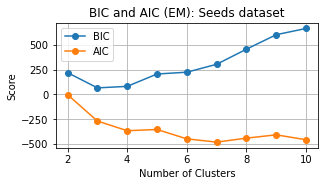

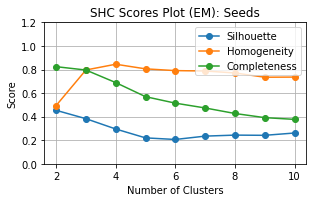

In [5]:
# Run EM for Seeds dataset
run_em(X_train_scaled_seeds, y_train_seeds, data_name='Seeds')

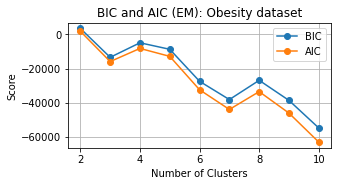

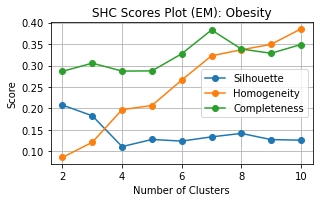

In [6]:
# Run EM for Obesity dataset
run_em(X_train_scaled_obesity, y_train_obesity, data_name='Obesity')

**2. K Means Clustering**

1. Select optimal number of clusters using elbow plot.
2. Evaluate the quality of the cluster count using silhouette, homogeneity and completeness scores.

In [7]:
def run_kmeans(X_train, y_train, max_clusters=10, data_name='Seeds'):
    inertia = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []

    cluster_range = range(2, max_clusters + 1)
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_train)
        
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_train, cluster_labels))
        homogeneity_scores.append(homogeneity_score(y_train, cluster_labels))
        completeness_scores.append(completeness_score(y_train, cluster_labels))

    # Plot Elbow Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(cluster_range, inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Plot (KM): {data_name}')
    #plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Silhouette, Homogeneity, and Completeness Scores
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette')
    plt.plot(cluster_range, homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(cluster_range, completeness_scores, marker='o', label='Completeness')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name=='Obesity':
        plt.ylim(0,0.65)
    plt.title(f'SHC Scores Plot (KM): {data_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

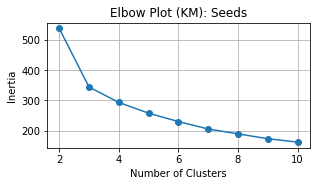

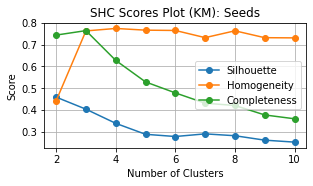

In [8]:
# Run KMeans for Seeds dataset
run_kmeans(X_train_scaled_seeds, y_train_seeds, data_name='Seeds')

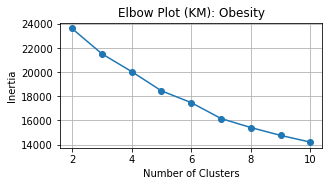

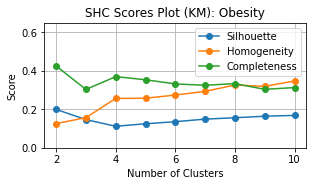

In [9]:
# Run KMeans for Obesity dataset
run_kmeans(X_train_scaled_obesity, y_train_obesity, data_name='Obesity')

# II. Dimension Reduction Techniques

This section will apply the following dimension reduction techniques on the training set of Seeds and Obesity datasets

1. Principal Component Analysis (PCA)
2. Independent Component Analysis (ICA)
3. Randomized Projections (RP)

**1. PCA**

1. Determine the principal components using explained variance and singular values plot.
2. Plot the original class labels against the first two principal components for visualization.

In [10]:
# Step 1: Determine the optimal number of principal components

def get_PCA(X_train, data_name):
    
    pca = PCA(random_state=42)
    X_pca = pca.fit_transform(X_train)
    explained_variance_ratio = pca.explained_variance_
    singular_values = pca.singular_values_

    # Create a single figure with 2 subplots (1 column, 2 rows)
    plt.figure(figsize=(4.2, 4.0))  # Adjusted height for two plots

    # Plot for Explained Variance by Components
    plt.subplot(2, 1, 1)  # (rows, columns, panel number)
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    plt.title(f'PCA Explained Variance: {data_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.grid()

    # Plot for Singular Values by Components
    plt.subplot(2, 1, 2)  # Next subplot
    plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o')
    plt.title(f'PCA Singular Values: {data_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Singular Values')
    plt.grid()

    # Show the combined plots
    plt.tight_layout()  # Adjusts subplot params for better spacing
    plt.show()

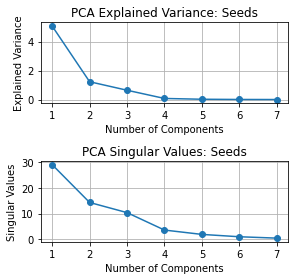

In [11]:
get_PCA(X_train_scaled_seeds, 'Seeds')

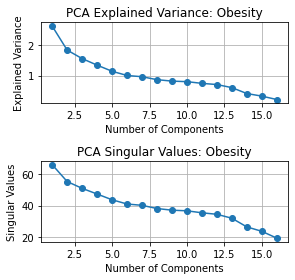

In [12]:
get_PCA(X_train_scaled_obesity, 'Obesity')

In [13]:
# Step 2: Plot original class labels on first two principal components for visualization

def plot_PCA_clusters(X_train, y_train, data_name, n_components=2):
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_train)

    plt.figure(figsize=(4.2, 4.0))
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.7)
    
    unique_labels = sorted(set(y_train))
    colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                          markerfacecolor=color, markersize=8) for label, color in zip(unique_labels, colors)]
    
    plt.legend(handles=handles, loc='best')
    
    # Plot settings
    plt.title(f'PCA Cluster Plot: {data_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    #plt.ylim(-4.5)
    plt.xlim(-5,7)
    plt.grid()
    plt.show()

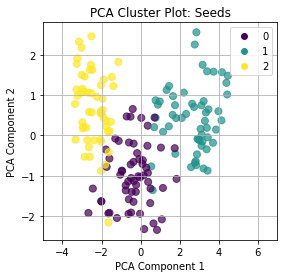

In [14]:
plot_PCA_clusters(X_train_scaled_seeds, y_train_seeds, 'Seeds', n_components=3)

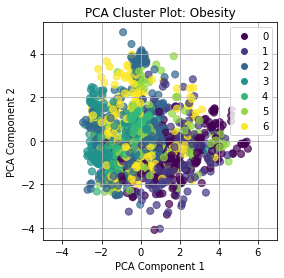

In [15]:
plot_PCA_clusters(X_train_scaled_obesity, y_train_obesity, 'Obesity', n_components=6)

**2. ICA**

1. Determine the optimal number of independent components using kurtosis and reconstructed error (MSE) plot.
2. Plot the original class labels against the first two independent components for visualization.

In [16]:
# Step 1: Determine the optimal number of independent components using kurtosis and reconstruction error plots.

def get_ICA(X_train, data_name):
    
    # Step 1: ICA
    ica = FastICA(random_state=42)
    X_ica = ica.fit_transform(X_train)  # Dimensionality-reduced data
    components_kurtosis = kurtosis(X_ica, axis=0)  # Kurtosis of components
    
    # Create a single figure with 2 subplots (1 column, 2 rows)
    plt.figure(figsize=(4.2, 4.0))  # Adjusted height for two plots

    # Plot 1: Kurtosis by Components
    plt.subplot(2, 1, 1)  # (rows, columns, panel number)
    plt.bar(range(1, len(components_kurtosis) + 1), components_kurtosis)
    plt.title(f'ICA Kurtosis: {data_name} dataset')
    plt.xlabel('Number of Components')
    plt.ylabel('Kurtosis')
    plt.grid()

    # Step 2: Reconstruction Error 
    reconstruction_error = []
    for n_components in range(1, X_train.shape[1] + 1):
        ica = FastICA(n_components=n_components, random_state=42)
        X_ica = ica.fit_transform(X_train)
        X_reconstructed = ica.inverse_transform(X_ica)
        error = np.sum((X_train - X_reconstructed) ** 2, axis=1).mean()  # Mean squared error
        reconstruction_error.append(error)

    # Plot 2: Reconstruction Error vs. Number of Components
    plt.subplot(2, 1, 2)  # (rows, columns, panel number)
    plt.plot(range(1, len(reconstruction_error) + 1), reconstruction_error, marker='o')
    plt.title(f'ICA Reconstruction Error: {data_name} dataset')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconst. Error (MSE)')
    plt.grid()
    
    # Show the combined plots
    plt.tight_layout()  # Adjusts subplot params for better spacing
    plt.show()
    
    #print(components_kurtosis)
    #print(reconstruction_error)

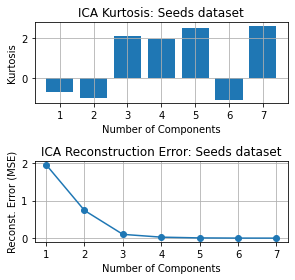

In [17]:
get_ICA(X_train_scaled_seeds, 'Seeds')

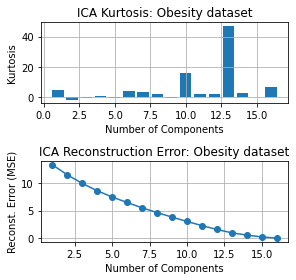

In [18]:
get_ICA(X_train_scaled_obesity, 'Obesity')

In [19]:
# Step 2: Plot original class labels on first two independent components for visualization

def plot_ICA_clusters(X_train, y_train, data_name, n_components):
    # Step 1: ICA
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_train)

    # Step 2: Plot ICA-reduced data with clusters (using ground truth labels)
    plt.figure(figsize=(4.9, 4.0))
    
    # Scatter plot using the first two ICA components
    scatter = plt.scatter(X_ica[:, 0], X_ica[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.7)
    
    # Set up legend manually with labels 1, 2, 3, etc., using unique classes in y_train
    unique_labels = sorted(set(y_train))
    colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    
    # Creating custom legend entries
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                          markerfacecolor=color, markersize=8) for label, color in zip(unique_labels, colors)]
    
    # Adding the custom legend with 'best' location
    plt.legend(handles=handles, loc='best')
    
    # Plot settings
    plt.title(f'ICA Cluster Plot: {data_name}')
    plt.xlabel('ICA Component 1')
    plt.ylabel('ICA Component 2')
    plt.xlim(-4.5,3)
    plt.grid()
    plt.show()

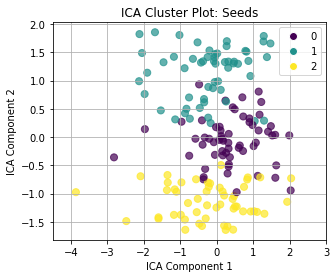

In [20]:
plot_ICA_clusters(X_train_scaled_seeds, y_train_seeds, 'Seeds', n_components=3)

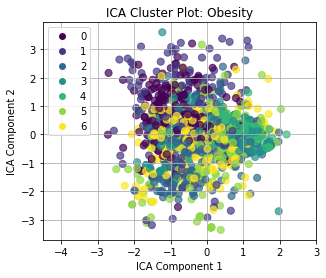

In [21]:
plot_ICA_clusters(X_train_scaled_obesity, y_train_obesity, 'Obesity', n_components=7)

**3. RP**

1. Determine the optimal number of random components using reconstructed error (MSE) plot.
2. Plot the original class labels against the first two random components for visualization.

In [22]:
# Step 1: Determine the optimal number of randomized projection components from the reconstruction error plot

def get_RP(X_train, data_name):
    
    reconstruction_errors = []
    components_range = range(1, X_train.shape[1])  

    for n_components in components_range:
        rp = GaussianRandomProjection(n_components=n_components, random_state=42)
        X_rp = rp.fit_transform(X_train)
        X_reconstructed = rp.inverse_transform(X_rp)
        error = mean_squared_error(X_train, X_reconstructed)
        reconstruction_errors.append(error)

    # Plotting the Reconstruction Error
    plt.figure(figsize=(4.2, 2.0))
    plt.plot(components_range, reconstruction_errors, marker='o')
    plt.title(f'RP Reconstruction Error: {data_name} dataset')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconst. Error (MSE)')
    plt.grid()
    plt.show()
    
    #print(reconstruction_errors)

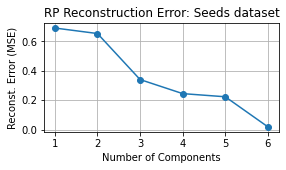

In [23]:
get_RP(X_train_scaled_seeds, 'Seeds')

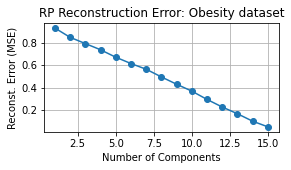

In [24]:
get_RP(X_train_scaled_obesity, 'Obesity')

In [25]:
# Step 2: Plot original class labels on first two random components for visualization

def plot_RP_clusters(X_train, y_train, data_name, n_components=2):
    
    rp = SparseRandomProjection(n_components=n_components, random_state=42)
    X_rp = rp.fit_transform(X_train)

    plt.figure(figsize=(4.9, 4.0))
    scatter = plt.scatter(X_rp[:, 0], X_rp[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.7)
    
    unique_labels = sorted(set(y_train))
    colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                          markerfacecolor=color, markersize=8) for label, color in zip(unique_labels, colors)]
       
    plt.legend(handles=handles, loc='best')
    plt.title(f'RP Cluster Plot: {data_name}')
    plt.xlabel('RP Component 1')
    plt.ylabel('RP Component 2')
    plt.grid()
    plt.show()

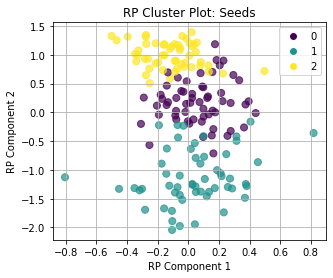

In [26]:
plot_RP_clusters(X_train_scaled_seeds, y_train_seeds, 'Seeds', n_components=3)

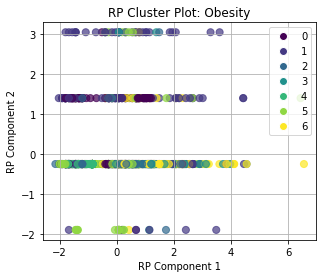

In [27]:
plot_RP_clusters(X_train_scaled_obesity, y_train_obesity, 'Obesity', n_components=7)

# III. Clustering on Dimension Reduced Datasets

The two clustering algorithms: 

    1. Expectation Maximization  
    2. K-means clustering  
    
is run on the Seeds and Obesity training datasets reduced using the following dimension reduction techniques: 

    1. Principal Component Analysis  
    2. Independent Component Analysis  
    3. Randomized Projections  

**1. Expectation Maxmization on PCA reduced dataset**

1. Apply the PCA transformation on the training dataset using optimal PCA components as identified from II above.
2. Apply the EM clustering on the PCA transformed dataset and 
3. Determine the optimal cluster count using the BIC/AIC plot and silhouette, homogeneity and completeness scores plot
4. Plot the EM generated clusters on the first two principal component axis for visualization.

In [28]:
def run_pca_em(X_train, y_train, data_name, max_clusters=10, num_components=3, optimal_k=4):
    
      
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []
    
    pca = PCA(n_components=num_components, random_state=42)
    X_pca = pca.fit_transform(X_train)
    
    for k in range(2, max_clusters + 1):
        em = GaussianMixture(n_components=k, random_state=42)
        em.fit(X_pca)
        labels = em.predict(X_pca)

        bic_scores.append(em.bic(X_pca))
        aic_scores.append(em.aic(X_pca))
        
        # Evaluation metrics
        silhouette_scores.append(silhouette_score(X_pca, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))
   
    # BIC and AIC Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC')
    plt.plot(range(2, max_clusters + 1), aic_scores, marker='o', label='AIC')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'BIC and AIC Plot (EM-PCA): {data_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Silhouette, Homogeneity, Completeness plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (EM-PCA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name=='Seeds':
        plt.ylim(0,1.4)
    else:
        plt.ylim(0,0.7)
    plt.legend()
    plt.grid()
    plt.show()

    # Step 3: Visualize Clusters using the first two PCA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    em = GaussianMixture(n_components=optimal_k, random_state=42)
    labels = em.fit_predict(X_pca)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_pca[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')

    plt.title(f'EM-PCA Cluster Plot: {data_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    if data_name=='Seeds':
        plt.ylim(-4,4)
    plt.grid()
    plt.show()

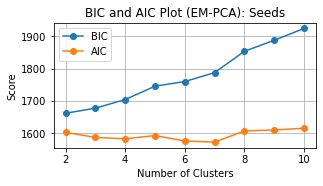

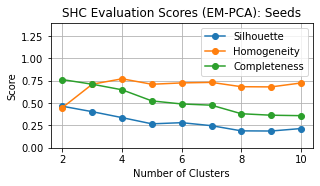

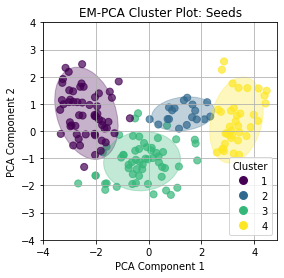

In [29]:
run_pca_em(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, num_components=3, optimal_k=4)

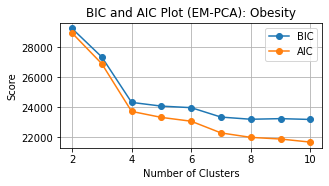

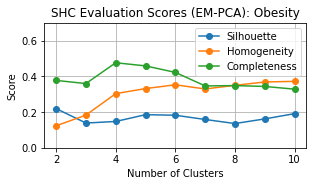

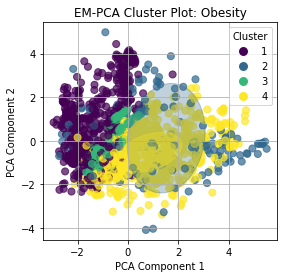

In [30]:
run_pca_em(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, num_components=6, optimal_k=4)

**2. K-means on PCA reduced dataset**

1. Apply the PCA transformation on the training dataset using optimal PCA components as identified from II above.
2. Apply the k-means clustering on the PCA transformed dataset and 
3. Determine the optimal cluster count using the elbow plot and silhouette, homogeneity and completeness scores plot
4. Plot the k-means generated clusters on the first two principal component axis for visualization.

In [31]:
def run_pca_km(X_train, y_train, data_name, max_clusters=10, n_components=3, optimal_k=3):
    
    # KMeans Clustering on PCA-reduced data
    inertia = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []


    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_train)


    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_pca)

        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_pca, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))
    
    
    # KMeans Elbow Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Plot (KM-PCA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    # KMeans Scores Plot 
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (KM-PCA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name=='Obesity':
        plt.ylim(0,0.6)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

   
    # Step 3: Visualize Clusters using the first two PCA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_pca[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')

    plt.title(f'KM-PCA Cluster Plot: {data_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid()
    plt.show()

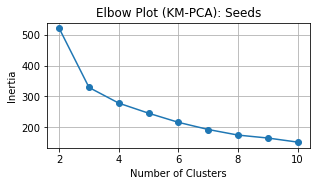

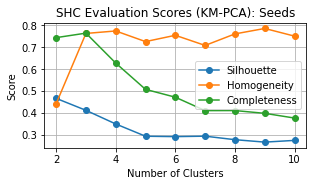

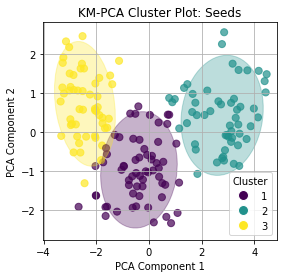

In [32]:
run_pca_km(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, n_components=3, optimal_k=3)

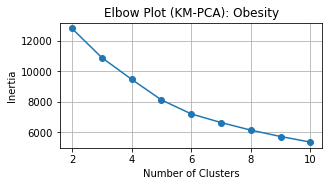

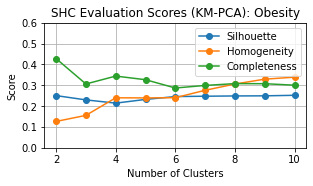

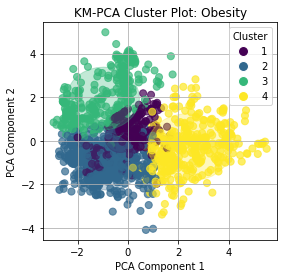

In [33]:
run_pca_km(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, n_components=6, optimal_k=4)

**3. Expectation Maxmization on ICA reduced dataset**

1. Apply the ICA transformation on the training dataset using optimal ICA components as identified from II above.
2. Apply the EM clustering on the ICA transformed dataset 
3. Determine the optimal cluster count using the BIC/AIC plot and silhouette, homogeneity and completeness scores plot
4. Plot the EM generated clusters on the first two independent component axis for visualization.

In [34]:
def run_ica_em(X_train, y_train, data_name, max_clusters=10, num_components=4, optimal_k=4):
        
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []
    
    ica = FastICA(n_components=num_components, random_state=42)
    X_ica = ica.fit_transform(X_train)

    for k in range(2, max_clusters + 1):
        em = GaussianMixture(n_components=k, random_state=42)
        em.fit(X_ica)
        labels = em.predict(X_ica)

        bic_scores.append(em.bic(X_ica))
        aic_scores.append(em.aic(X_ica))
        
        # Evaluation metrics
        silhouette_scores.append(silhouette_score(X_ica, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))
      
    # Plot BIC and AIC Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC')
    plt.plot(range(2, max_clusters + 1), aic_scores, marker='o', label='AIC')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'BIC and AIC Plot (EM-ICA): {data_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # EM Scores Plot (Silhouette, Homogeneity, Completeness)
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (EM-ICA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name=='Seeds':
        plt.ylim(0,1.4)
    plt.legend()
    plt.grid()
    plt.show()

    # Step 3: Visualize Clusters using the first two PCA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    em = GaussianMixture(n_components=optimal_k, random_state=42)
    labels = em.fit_predict(X_ica)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_ica[:, 0], X_ica[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_ica[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')

    plt.title(f'EM-ICA Cluster Plot: {data_name}')
    plt.xlabel('ICA Component 1')
    plt.ylabel('ICA Component 2')
    plt.grid()
    plt.show()

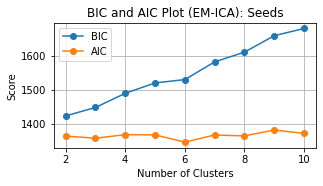

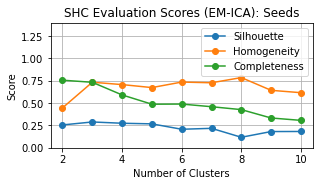

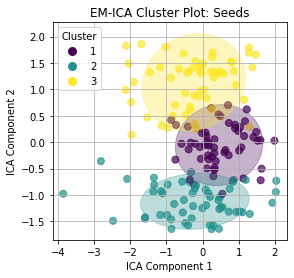

In [35]:
run_ica_em(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, num_components=3, optimal_k=3)

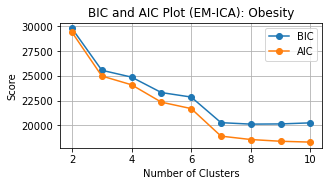

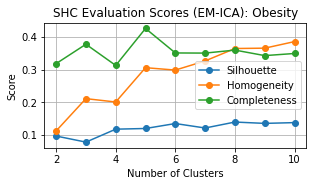

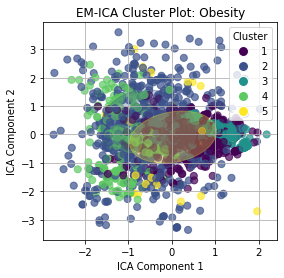

In [36]:
run_ica_em(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, num_components=7, optimal_k=5)

**4. K-means on ICA reduced dataset**

1. Apply the ICA transformation on the training dataset using optimal ICA components as identified from II above.
2. Apply the k-means clustering on the ICA transformed dataset  
3. Determine the optimal cluster count using the elbow plot and silhouette, homogeneity and completeness scores plot
4. Plot the k-means generated clusters on the first two independent component axis for visualization.

In [37]:
def run_ica_km(X_train, y_train, data_name, max_clusters=10, n_components=3, optimal_k=3):
    
    
    # KMeans Clustering on ICA-reduced data
    inertia = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []


    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_train)
    
    

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_ica)

        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_ica, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))

    # KMeans Elbow Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Plot (KM-ICA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    # KMeans Scores Plot (Silhouette, Homogeneity, Completeness)
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (KM-ICA): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Visualize Clusters using the first two ICA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_ica)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_ica[:, 0], X_ica[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_ica[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')


    plt.title(f'KM-ICA Cluster Plot: {data_name}')
    plt.xlabel('ICA Component 1')
    plt.ylabel('ICA Component 2')
    plt.grid()
    plt.show()

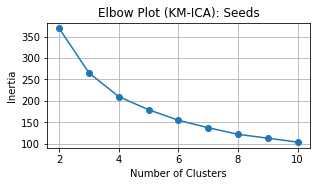

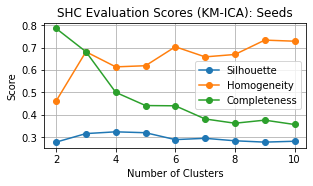

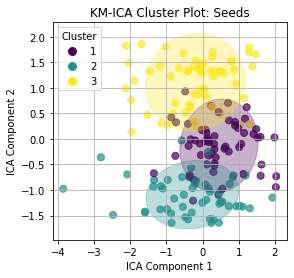

In [38]:
run_ica_km(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, n_components=3, optimal_k=3)

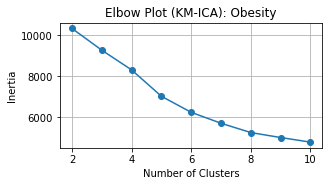

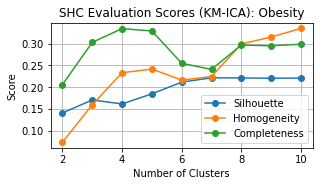

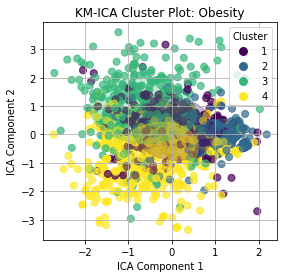

In [39]:
run_ica_km(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, n_components=7, optimal_k=4)

**5. Expectation Maxmization on RP reduced dataset**

1. Apply the RP transformation on the training dataset using optimal RP components as identified from II above.
2. Apply the EM clustering on the RP transformed dataset 
3. Determine the optimal cluster count using the BIC/AIC plot and silhouette, homogeneity and completeness scores plot
4. Plot the EM generated clusters on the first two random component axis for visualization.

In [40]:
def run_rp_em(X_train, y_train, data_name, max_clusters=10, num_components=3, optimal_k=3):
    
    
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []
    
    rp = GaussianRandomProjection(n_components=num_components, random_state=42)
    X_rp = rp.fit_transform(X_train)
    
    for k in range(2, max_clusters + 1):
        em = GaussianMixture(n_components=k, random_state=42)
        em.fit(X_rp)
        labels = em.predict(X_rp)

        bic_scores.append(em.bic(X_rp))
        aic_scores.append(em.aic(X_rp))
        
        silhouette_scores.append(silhouette_score(X_rp, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))
        
       
    # Plot BIC and AIC Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC')
    plt.plot(range(2, max_clusters + 1), aic_scores, marker='o', label='AIC')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'BIC and AIC Plot (EM-RP): {data_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # EM Scores Plot (Silhouette, Homogeneity, Completeness)
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (EM-RP): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    if data_name=='Seeds':
        plt.ylim(-0.1,0.82)
    plt.legend()
    plt.grid()
    plt.show()

    # Step 3: Visualize Clusters using the first two PCA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    em = GaussianMixture(n_components=optimal_k, random_state=42)
    labels = em.fit_predict(X_rp)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_rp[:, 0], X_rp[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_rp[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')
    
    

    
    plt.title(f'EM-RP Cluster Plot: {data_name}')
    plt.xlabel('RP Component 1')
    plt.ylabel('RP Component 2')
    plt.grid()
    plt.show()

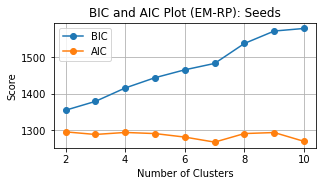

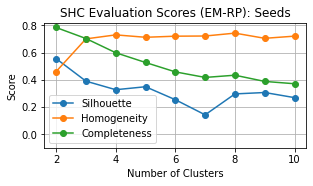

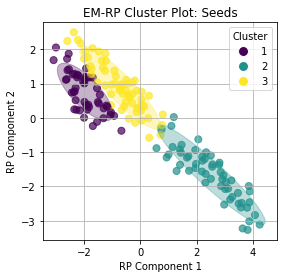

In [41]:
run_rp_em(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, num_components=3, optimal_k=3)

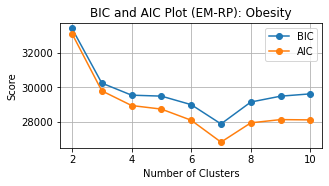

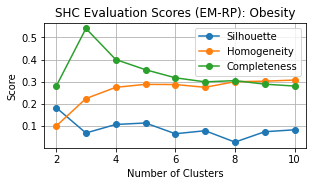

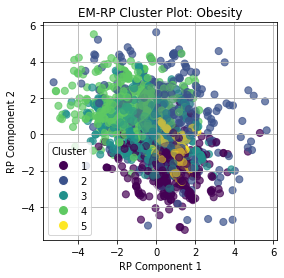

In [42]:
run_rp_em(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, num_components=6, optimal_k=5)

**6. K-means on RP reduced dataset**

1. Apply the RP transformation on the training dataset using optimal RP components as identified from II above.
2. Apply the k-means clustering on the RP transformed dataset  
3. Determine the optimal cluster count using the elbow plot and silhouette, homogeneity and completeness scores plot
4. Plot the k-means generated clusters on the first two random component axis for visualization.

In [44]:
def run_rp_km(X_train, y_train, data_name, max_clusters=10, n_components=3, optimal_k=3):
    
    
    # KMeans Clustering on RP-reduced data
    inertia = []
    silhouette_scores = []
    homogeneity_scores = []
    completeness_scores = []

   
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    X_rp = rp.fit_transform(X_train)
    
    

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_rp)

        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_rp, labels))
        homogeneity_scores.append(homogeneity_score(labels_true=y_train, labels_pred=labels))
        completeness_scores.append(completeness_score(labels_true=y_train, labels_pred=labels))

    # KMeans Elbow Plot
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Plot (KM-RP): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    # KMeans Scores Plot (Silhouette, Homogeneity, Completeness)
    plt.figure(figsize=(4.7, 2.3))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range(2, max_clusters + 1), homogeneity_scores, marker='o', label='Homogeneity')
    plt.plot(range(2, max_clusters + 1), completeness_scores, marker='o', label='Completeness')
    plt.title(f'SHC Evaluation Scores (KM-RP): {data_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Step 3: Visualize Clusters using the first two PCA components
    plt.figure(figsize=(4.2, 4.0))

    # Get the predicted cluster labels for the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_rp)

    # Scatter plot using the first two principal components
    scatter = plt.scatter(X_rp[:, 0], X_rp[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)

    # Function to add ellipses around clusters
    def plot_ellipse(mean, cov, ax, color):
        # Adjusting the width and height of the ellipse to better cover the cluster
        v, w = np.linalg.eigh(cov)
        v = 4.0 * np.sqrt(v)  

        # Calculate angle of the ellipse based on eigenvectors
        angle = np.arctan2(w[1, 0], w[0, 0])
        angle = np.degrees(angle)

        # Create and add the ellipse with the same color as the points
        ellipse = mpatches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.3)
        ax.add_patch(ellipse)

    # Calculate and plot ellipses for each cluster
    ax = plt.gca()
    for i in range(optimal_k):
        # Extract points that belong to the current cluster
        cluster_points = X_rp[labels == i]

        # Calculate mean and covariance for the cluster
        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points.T)

        # Get color for the ellipse from the scatter plot colormap
        color = scatter.cmap(scatter.norm(i))

        # Plot ellipse for the cluster
        plot_ellipse(mean, cov, ax, color)

    # Set legend with the same colors as the scatter plot
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i + 1}', 
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) 
               for i in unique_labels]

    plt.legend(handles=handles, title='Cluster', loc='best')

    plt.title(f'KM-RP Cluster Plot: {data_name}')
    plt.xlabel('RP Component 1')
    plt.ylabel('RP Component 2')
    plt.grid()
    plt.show()

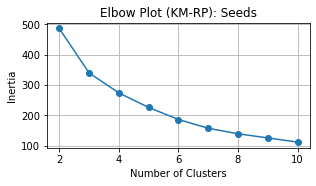

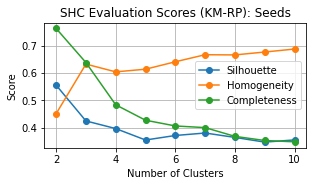

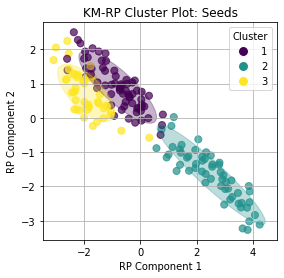

In [45]:
run_rp_km(X_train_scaled_seeds, y_train_seeds, data_name='Seeds', max_clusters=10, n_components=3, optimal_k=3)

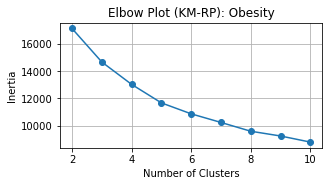

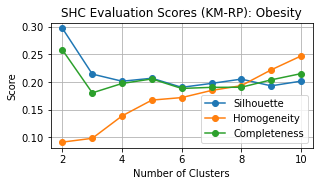

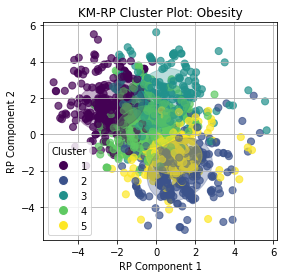

In [46]:
run_rp_km(X_train_scaled_obesity, y_train_obesity, data_name='Obesity', max_clusters=10, n_components=6, optimal_k=5)

# Neural Network Analysis

Analyze the performance of NN model trained in A1 on Seeds dataset

1. Dimensionally reduced dataset with no clustering
2. Dimension reduced dataset with clustering

**1. Dimension reduced datasets with no clustering**

1. Define the NN model with optimized hyperparameters determined in Assignment 1
2. Transform the Seeds training dataset using PCA, ICA and RP separately.
3. Obtain the learning curves of the NN model on the reduced datasets to analyze training and CV accuracy.
4. Predict on the test dataset and output training accuracy, testing accuracy and wall-clock times.

In [47]:
# Define a NN classifier with optimized configurations from A1

mlp = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

In [48]:
# Apply dimension reduction on dataset with no cluster 


# Optimal PCA n_components=3 from III above
pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_seeds)
X_test_pca = pca.transform(X_test_scaled_seeds)

# Optimal ICA n_components=4 from III above
ica = FastICA(n_components=4, random_state=42)
X_train_ica = ica.fit_transform(X_train_scaled_seeds)
X_test_ica = ica.transform(X_test_scaled_seeds)

# Optimal RP n_components=3 from III above
rp = GaussianRandomProjection(n_components=3, random_state=42)
X_train_rp = rp.fit_transform(X_train_scaled_seeds)
X_test_rp = rp.transform(X_test_scaled_seeds)

In [49]:
# Define the range of epochs (number of iterations)
param_range = np.arange(1, 115, 10)

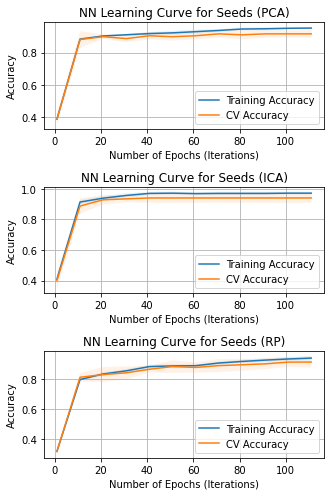

In [50]:
# Generate the learning curve using cross-validation

# PCA-No cluster learning curve
train_scores, val_scores = validation_curve(mlp, X_train_pca, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_pca = np.mean(train_scores, axis=1)
train_std_pca = np.std(train_scores, axis=1)
val_mean_pca = np.mean(val_scores, axis=1)
val_std_pca = np.std(val_scores, axis=1)

# ICA-No cluster learning curve
train_scores, val_scores = validation_curve(mlp, X_train_ica, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_ica = np.mean(train_scores, axis=1)
train_std_ica = np.std(train_scores, axis=1)
val_mean_ica = np.mean(val_scores, axis=1)
val_std_ica = np.std(val_scores, axis=1)

# RP-No cluster learning curve
train_scores, val_scores = validation_curve(mlp, X_train_rp, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_rp = np.mean(train_scores, axis=1)
train_std_rp = np.std(train_scores, axis=1)
val_mean_rp = np.mean(val_scores, axis=1)
val_std_rp = np.std(val_scores, axis=1)


# Plotting the learning curve with epochs as the x-axis

plt.figure(figsize=(4.7, 7.0))
plt.subplot(3, 1, 1)
plt.plot(param_range, train_mean_pca, label="Training Accuracy")
plt.plot(param_range, val_mean_pca, label="CV Accuracy")

plt.fill_between(param_range, train_mean_pca - train_std_pca, train_mean_pca + train_std_pca, alpha=0.1)
plt.fill_between(param_range, val_mean_pca - val_std_pca, val_mean_pca + val_std_pca, alpha=0.1)

plt.title("NN Learning Curve for Seeds (PCA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 2)
#plt.figure(figsize=(4.7, 2.3))
plt.plot(param_range, train_mean_ica, label="Training Accuracy")
plt.plot(param_range, val_mean_ica, label="CV Accuracy")

plt.fill_between(param_range, train_mean_ica - train_std_ica, train_mean_ica + train_std_ica, alpha=0.1)
plt.fill_between(param_range, val_mean_ica - val_std_ica, val_mean_ica + val_std_ica, alpha=0.1)

plt.title("NN Learning Curve for Seeds (ICA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 3)
#plt.figure(figsize=(4.7, 2.3))
plt.plot(param_range, train_mean_rp, label="Training Accuracy")
plt.plot(param_range, val_mean_rp, label="CV Accuracy")

plt.fill_between(param_range, train_mean_rp - train_std_rp, train_mean_rp + train_std_rp, alpha=0.1)
plt.fill_between(param_range, val_mean_rp - val_std_rp, val_mean_rp + val_std_rp, alpha=0.1)

plt.title("NN Learning Curve for Seeds (RP)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the combined plots
plt.tight_layout()  # Adjusts subplot params for better spacing
plt.show()

In [51]:
# Define final MLP Classifier for PCA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_pca = time.time()
mlp_final.fit(X_train_pca,y_train_seeds)
end_time_pca = time.time()

# Calculate train and test accuracy
train_accuracy_pca=mlp_final.score(X_train_pca, y_train_seeds)
test_accuracy_pca=mlp_final.score(X_test_pca, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_pca = end_time_pca-start_time_pca


# Define final MLP Classifier for ICA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_ica = time.time()
mlp_final.fit(X_train_ica,y_train_seeds)
end_time_ica = time.time()

# Calculate train and test accuracy
train_accuracy_ica=mlp_final.score(X_train_ica, y_train_seeds)
test_accuracy_ica=mlp_final.score(X_test_ica, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_ica = end_time_ica-start_time_ica


# Define final MLP Classifier for RP

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_rp = time.time()
mlp_final.fit(X_train_rp,y_train_seeds)
end_time_rp = time.time()

# Calculate train and test accuracy
train_accuracy_rp=mlp_final.score(X_train_rp, y_train_seeds)
test_accuracy_rp=mlp_final.score(X_test_rp, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_rp = end_time_rp-start_time_rp

print('##### PCA, ICA and RP with No cluster ########\n')

print(f'PCA training accuracy: {train_accuracy_pca:.3f}')
print(f'PCA testing accuracy: {test_accuracy_pca:.3f}')
print(f'PCA wall-clock time: {wall_clock_time_pca:.3f} seconds\n\n')

print(f'ICA training accuracy: {train_accuracy_ica:.3f}')
print(f'ICA testing accuracy: {test_accuracy_ica:.3f}')
print(f'ICA wall-clock time: {wall_clock_time_ica:.3f} seconds\n\n')

print(f'RP training accuracy: {train_accuracy_rp:.3f}')
print(f'RP testing accuracy: {test_accuracy_rp:.3f}')
print(f'RP wall-clock time: {wall_clock_time_rp:.3f} seconds')

##### PCA, ICA and RP with No cluster ########

PCA training accuracy: 0.988
PCA testing accuracy: 0.833
PCA wall-clock time: 1.459 seconds


ICA training accuracy: 1.000
ICA testing accuracy: 0.952
ICA wall-clock time: 1.302 seconds


RP training accuracy: 0.982
RP testing accuracy: 0.857
RP wall-clock time: 2.210 seconds


## Dimension reduced datasets with clustering

**Dimension reduced dataset with EM cluster information**

1. Generate the EM clusters on Seeds dataset with the optimal cluster count as determined previously
2. Combine the EM cluster information as additional feature on the previously reduced Seeds dataset
3. Define the NN model using optimized hyperparameters from A1 and fit on training datasets to obtain learning curves.
4. Predict on the test dataset and output training accuracy, testing accuracy and wall-clock times.  

In [52]:
# Define a NN classifier with optimized configurations from A1
mlp = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

In [53]:
# Generate clusters of the dataset (n_components=4 was found optimum from previous analysis)

em = GaussianMixture(n_components=4, random_state=42)
X_train_em = em.fit_predict(X_train_scaled_seeds)
X_test_em = em.predict(X_test_scaled_seeds)

In [54]:
# Combine dimension reduced data with em clusters features

X_train_pca_em = np.hstack((X_train_pca, X_train_em.reshape(-1, 1)))
X_test_pca_em = np.hstack((X_test_pca, X_test_em.reshape(-1, 1)))

X_train_ica_em = np.hstack((X_train_ica, X_train_em.reshape(-1, 1)))
X_test_ica_em = np.hstack((X_test_ica, X_test_em.reshape(-1, 1)))

X_train_rp_em = np.hstack((X_train_rp, X_train_em.reshape(-1, 1)))
X_test_rp_em = np.hstack((X_test_rp, X_test_em.reshape(-1, 1)))

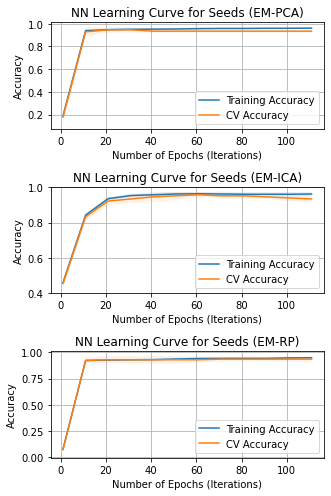

In [55]:
# Generate the learning curve using cross-validation on dimension reduced datasets with EM clusters

# PCA-EM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_pca_em, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_pca_em = np.mean(train_scores, axis=1)
train_std_pca_em = np.std(train_scores, axis=1)
val_mean_pca_em = np.mean(val_scores, axis=1)
val_std_pca_em = np.std(val_scores, axis=1)

# ICA-EM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_ica_em, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_ica_em = np.mean(train_scores, axis=1)
train_std_ica_em = np.std(train_scores, axis=1)
val_mean_ica_em = np.mean(val_scores, axis=1)
val_std_ica_em = np.std(val_scores, axis=1)

# RP-EM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_rp_em, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_rp_em = np.mean(train_scores, axis=1)
train_std_rp_em = np.std(train_scores, axis=1)
val_mean_rp_em = np.mean(val_scores, axis=1)
val_std_rp_em = np.std(val_scores, axis=1)

plt.figure(figsize=(4.7, 7.0))


# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 1)
plt.plot(param_range, train_mean_pca_em, label="Training Accuracy")
plt.plot(param_range, val_mean_pca_em, label="CV Accuracy")

plt.fill_between(param_range, train_mean_pca_em - train_std_pca_em, train_mean_pca_em + train_std_pca_em, alpha=0.1)
plt.fill_between(param_range, val_mean_pca_em - val_std_pca_em, val_mean_pca_em + val_std_pca_em, alpha=0.1)

plt.title("NN Learning Curve for Seeds (EM-PCA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 2)
plt.plot(param_range, train_mean_ica_em, label="Training Accuracy")
plt.plot(param_range, val_mean_ica_em, label="CV Accuracy")

plt.fill_between(param_range, train_mean_ica_em - train_std_ica_em, train_mean_ica_em + train_std_ica_em, alpha=0.1)
plt.fill_between(param_range, val_mean_ica_em - val_std_ica_em, val_mean_ica_em + val_std_ica_em, alpha=0.1)

plt.title("NN Learning Curve for Seeds (EM-ICA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 3)
plt.plot(param_range, train_mean_rp_em, label="Training Accuracy")
plt.plot(param_range, val_mean_rp_em, label="CV Accuracy")

plt.fill_between(param_range, train_mean_rp_em - train_std_rp_em, train_mean_rp_em + train_std_rp_em, alpha=0.1)
plt.fill_between(param_range, val_mean_rp_em - val_std_rp_em, val_mean_rp_em + val_std_rp_em, alpha=0.1)

plt.title("NN Learning Curve for Seeds (EM-RP)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the combined plots
plt.tight_layout()  # Adjusts subplot params for better spacing
plt.show()

In [56]:
# Define final MLP Classifier for EM-PCA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_pca_em = time.time()
mlp_final.fit(X_train_pca_em,y_train_seeds)
end_time_pca_em = time.time()

# Calculate train and test accuracy
train_accuracy_pca_em=mlp_final.score(X_train_pca_em, y_train_seeds)
test_accuracy_pca_em=mlp_final.score(X_test_pca_em, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_pca_em = end_time_pca_em-start_time_pca_em


# Define final MLP Classifier for ICA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_ica_em = time.time()
mlp_final.fit(X_train_ica_em,y_train_seeds)
end_time_ica_em = time.time()

# Calculate train and test accuracy
train_accuracy_ica_em=mlp_final.score(X_train_ica_em, y_train_seeds)
test_accuracy_ica_em=mlp_final.score(X_test_ica_em, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_ica_em = end_time_ica_em-start_time_ica_em


# Define final MLP Classifier for RP

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_rp_em = time.time()
mlp_final.fit(X_train_rp_em,y_train_seeds)
end_time_rp_em = time.time()

# Calculate train and test accuracy
train_accuracy_rp_em=mlp_final.score(X_train_rp_em, y_train_seeds)
test_accuracy_rp_em=mlp_final.score(X_test_rp_em, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_rp_em = end_time_rp_em-start_time_rp_em

print('##### PCA, ICA and RP with EM cluster ########\n')

print(f'EM-PCA training accuracy: {train_accuracy_pca_em:.3f}')
print(f'EM-PCA testing accuracy: {test_accuracy_pca_em:.3f}')
print(f'EM-PCA wall-clock time: {wall_clock_time_pca_em:.3f} seconds\n\n')

print(f'EM-ICA training accuracy: {train_accuracy_ica_em:.3f}')
print(f'EM-ICA testing accuracy: {test_accuracy_ica_em:.3f}')
print(f'EM-ICA wall-clock time: {wall_clock_time_ica_em:.3f} seconds\n\n')

print(f'EM-RP training accuracy: {train_accuracy_rp_em:.3f}')
print(f'EM-RP testing accuracy: {test_accuracy_rp_em:.3f}')
print(f'EM-RP wall-clock time: {wall_clock_time_rp_em:.3f} seconds')

##### PCA, ICA and RP with EM cluster ########

EM-PCA training accuracy: 0.994
EM-PCA testing accuracy: 0.905
EM-PCA wall-clock time: 1.199 seconds


EM-ICA training accuracy: 1.000
EM-ICA testing accuracy: 0.905
EM-ICA wall-clock time: 1.681 seconds


EM-RP training accuracy: 0.982
EM-RP testing accuracy: 0.929
EM-RP wall-clock time: 1.303 seconds


**Dimension reduced dataset with K-means cluster information**

1. Generate the k-means clusters on Seeds dataset with the optimal cluster count as determined previously
2. Combine the k-means cluster information as additional feature on the previously reduced Seeds dataset
3. Define the NN model using optimized hyperparameters from A1 and fit on training datasets to obtain learning curves.
4. Predict on the test dataset and output training accuracy, testing accuracy and wall-clock times.  

In [57]:
# Generate clusters of the dataset (n_clusters=3 was found optimum from previous analysis)

kmeans = KMeans(n_clusters=3, random_state=42)
X_train_km = kmeans.fit_predict(X_train_scaled_seeds)
X_test_km = kmeans.predict(X_test_scaled_seeds)

In [58]:
# Combine dimension reduced data with km clusters features

X_train_pca_km = np.hstack((X_train_pca, X_train_km.reshape(-1, 1)))
X_test_pca_km = np.hstack((X_test_pca, X_test_km.reshape(-1, 1)))

X_train_ica_km = np.hstack((X_train_ica, X_train_km.reshape(-1, 1)))
X_test_ica_km = np.hstack((X_test_ica, X_test_km.reshape(-1, 1)))

X_train_rp_km = np.hstack((X_train_rp, X_train_km.reshape(-1, 1)))
X_test_rp_km = np.hstack((X_test_rp, X_test_km.reshape(-1, 1)))

In [59]:
# Define MLP Classifier for KM-PCA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

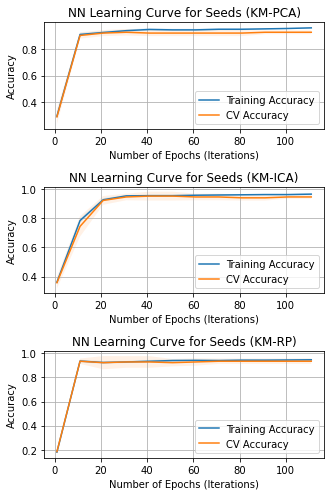

In [60]:
# Generate the learning curve using cross-validation on dimension reduced datasets with EM clusters

# PCA-KM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_pca_km, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_pca_km = np.mean(train_scores, axis=1)
train_std_pca_km = np.std(train_scores, axis=1)
val_mean_pca_km = np.mean(val_scores, axis=1)
val_std_pca_km = np.std(val_scores, axis=1)

# ICA-KM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_ica_km, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_ica_km = np.mean(train_scores, axis=1)
train_std_ica_km = np.std(train_scores, axis=1)
val_mean_ica_km = np.mean(val_scores, axis=1)
val_std_ica_km = np.std(val_scores, axis=1)

# RP-KM learning curve
train_scores, val_scores = validation_curve(mlp, X_train_rp_km, y_train_seeds, param_name="max_iter", param_range=param_range, 
                                            cv=5, scoring="accuracy", n_jobs=-1)
train_mean_rp_km = np.mean(train_scores, axis=1)
train_std_rp_km = np.std(train_scores, axis=1)
val_mean_rp_km = np.mean(val_scores, axis=1)
val_std_rp_km = np.std(val_scores, axis=1)

plt.figure(figsize=(4.7, 7.0))


# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 1)
plt.plot(param_range, train_mean_pca_km, label="Training Accuracy")
plt.plot(param_range, val_mean_pca_km, label="CV Accuracy")

plt.fill_between(param_range, train_mean_pca_km - train_std_pca_km, train_mean_pca_km + train_std_pca_km, alpha=0.1)
plt.fill_between(param_range, val_mean_pca_km - val_std_pca_km, val_mean_pca_km + val_std_pca_km, alpha=0.1)

plt.title("NN Learning Curve for Seeds (KM-PCA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 2)
plt.plot(param_range, train_mean_ica_km, label="Training Accuracy")
plt.plot(param_range, val_mean_ica_km, label="CV Accuracy")

plt.fill_between(param_range, train_mean_ica_km - train_std_ica_km, train_mean_ica_km + train_std_ica_km, alpha=0.1)
plt.fill_between(param_range, val_mean_ica_km - val_std_ica_km, val_mean_ica_km + val_std_ica_km, alpha=0.1)

plt.title("NN Learning Curve for Seeds (KM-ICA)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Plotting the learning curve with epochs as the x-axis
plt.subplot(3, 1, 3)
plt.plot(param_range, train_mean_rp_km, label="Training Accuracy")
plt.plot(param_range, val_mean_rp_km, label="CV Accuracy")

plt.fill_between(param_range, train_mean_rp_km - train_std_rp_km, train_mean_rp_km + train_std_rp_km, alpha=0.1)
plt.fill_between(param_range, val_mean_rp_km - val_std_rp_km, val_mean_rp_km + val_std_rp_km, alpha=0.1)

plt.title("NN Learning Curve for Seeds (KM-RP)")
plt.xlabel("Number of Epochs (Iterations)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the combined plots
plt.tight_layout()  # Adjusts subplot params for better spacing
plt.show()

In [61]:
# Define final MLP Classifier for KM-PCA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_pca_km = time.time()
mlp_final.fit(X_train_pca_km,y_train_seeds)
end_time_pca_km = time.time()

# Calculate train and test accuracy
train_accuracy_pca_km=mlp_final.score(X_train_pca_km, y_train_seeds)
test_accuracy_pca_km=mlp_final.score(X_test_pca_km, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_pca_km = end_time_pca_km-start_time_pca_km


# Define final MLP Classifier for ICA

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_ica_km = time.time()
mlp_final.fit(X_train_ica_km,y_train_seeds)
end_time_ica_km = time.time()

# Calculate train and test accuracy
train_accuracy_ica_km=mlp_final.score(X_train_ica_km, y_train_seeds)
test_accuracy_ica_km=mlp_final.score(X_test_ica_km, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_ica_km = end_time_ica_km-start_time_ica_km


# Define final MLP Classifier for RP

mlp_final = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.003, max_iter=1000, warm_start=True, 
                          random_state=42) # hidden_layer_size=(100,) and learning_rate_init=0.003 are optimum from A1

# Fit the model on train data
start_time_rp_km = time.time()
mlp_final.fit(X_train_rp_km,y_train_seeds)
end_time_rp_km = time.time()

# Calculate train and test accuracy
train_accuracy_rp_km=mlp_final.score(X_train_rp_km, y_train_seeds)
test_accuracy_rp_km=mlp_final.score(X_test_rp_km, y_test_seeds)

# Calculate wall-clock time
wall_clock_time_rp_km = end_time_rp_km-start_time_rp_km

print('##### PCA, ICA and RP with KM cluster ########\n')

print(f'KM-PCA training accuracy: {train_accuracy_pca_km:.3f}')
print(f'KM-PCA testing accuracy: {test_accuracy_pca_km:.3f}')
print(f'KM-PCA wall-clock time: {wall_clock_time_pca_km:.3f} seconds\n\n')

print(f'KM-ICA training accuracy: {train_accuracy_ica_km:.3f}')
print(f'KM-ICA testing accuracy: {test_accuracy_ica_km:.3f}')
print(f'KM-ICA wall-clock time: {wall_clock_time_ica_km:.3f} seconds\n\n')

print(f'KM-RP training accuracy: {train_accuracy_rp_km:.3f}')
print(f'KM-RP testing accuracy: {test_accuracy_rp_km:.3f}')
print(f'KM-RP wall-clock time: {wall_clock_time_rp_km:.3f} seconds')

##### PCA, ICA and RP with KM cluster ########

KM-PCA training accuracy: 0.988
KM-PCA testing accuracy: 0.833
KM-PCA wall-clock time: 1.235 seconds


KM-ICA training accuracy: 1.000
KM-ICA testing accuracy: 0.929
KM-ICA wall-clock time: 1.214 seconds


KM-RP training accuracy: 0.982
KM-RP testing accuracy: 0.857
KM-RP wall-clock time: 1.909 seconds
